# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

## Truncated-SVD

In [1]:
#importing important libarary

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

In [2]:
import math

In [3]:
con = sqlite3.connect("database.sqlite")

In [4]:
amzn = pd.read_sql_query('''SELECT * 
                            FROM Reviews 
                            WHERE Score != 3 
                            ORDER BY Time''', con)

In [5]:
def partition(score):
    if score < 3:
        return 0
    else : 
        return 1
amzn_score = amzn["Score"] 
filter_amzn = amzn_score.map(partition)
amzn['Score'] = filter_amzn

In [6]:
#sorting data
sorted_data = amzn.sort_values("ProductId", axis = 0, ascending = True, \
                       inplace = False, na_position = 'last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [9]:
final = final.iloc[0:50000]

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 50000/50000 [01:38<00:00, 506.61it/s]


In [13]:
#splitting data into train and test
x_train = preprocessed_reviews[slice(0,50000)]

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [14]:
# Please write all the code with proper documentation

In [15]:
max_features = 1000

In [16]:
def tfidf(preprocessed_reviews):
    tf_idf_vect = TfidfVectorizer(min_df = 20, max_features = max_features)
    vectorizer = tf_idf_vect.fit_transform(preprocessed_reviews)
    return vectorizer, tf_idf_vect



#vectorizing using above function
tfidf_x_train, tfidf_vect = tfidf(x_train)
tfidf_vect.idf_.shape


(1000,)

In [17]:
top_2000_words  = tfidf_vect.get_feature_names()

### [5.2] Calulation of Co-occurrence matrix

In [18]:
# Please write all the code with proper documentation

In [19]:
cooc_mat = np.zeros((max_features, max_features), dtype=int)
cooc_mat.shape

(1000, 1000)

In [20]:
from tqdm import tqdm_notebook as tqdm
preprocessed_reviews1 = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    #https://gist.github.com/sebleier/554280
    #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    sentance = ' '.join(e.lower() for e in sentance.split())
    preprocessed_reviews1.append(sentance.strip())

In [22]:
# making co-occurance matric with window size 5(5 left and 5 right)

for loc_i,key_word in enumerate(tqdm(top_2000_words)):
    for sent in preprocessed_reviews1:
        len_of_sent = len(sent.split())
        for i,word in enumerate(sent.split()):
            if key_word == word:
                for k in range(i-5, i+6):
                    if k <= (len_of_sent-1) and k >= 0 and k != i: 
                        match_word = sent.split()[k]
                        for loc_j,word_check in enumerate(top_2000_words):                        
                            if word_check == match_word:
                                cooc_mat[loc_i,loc_j] = cooc_mat[loc_i,loc_j] + 1                          

In [23]:
cooc_mat

array([[1663,    2,    2, ...,    4,    2,    2],
       [   2, 1369,    2, ...,    2,    8,   10],
       [   2,    2,  423, ...,    0,    0,    0],
       ...,
       [   2,    1,    0, ...,  134,    3,    0],
       [   1,    4,    0, ...,    3,   26,    0],
       [   1,    5,    0, ...,    0,    0,    8]])

In [24]:
features = tfidf_vect.get_feature_names()
cooc_mat_df = pd.DataFrame(cooc_mat, columns = features, index  = features) 

In [25]:
print("Co-occurance Matrix")
cooc_mat_df.head(3)

Co-occurance Matrix


,able,absolutely,acid,across,actually,add,added,adding,addition,adds,...,years,yeast,yellow,yes,yet,yogi,yogurt,yum,yummy,zico
able,1663,2,2,0,24,14,4,4,0,0,...,46,2,0,4,12,0,2,4,2,2
absolutely,2,1369,2,2,6,6,10,4,0,0,...,26,2,0,8,4,4,2,2,8,10
acid,2,2,423,0,6,4,6,0,2,0,...,4,2,10,0,0,0,2,0,0,0


### [5.3] Finding optimal value for number of components (n) to be retained.

In [26]:
# Please write all the code with proper documentation

In [27]:
from sklearn.decomposition import TruncatedSVD
sum_exp_var = []
for i in tqdm(range(len(features))):
    svd = TruncatedSVD(n_components=i, random_state=42)
    svd.fit(cooc_mat_df)
    sum_exp_var.append(svd.explained_variance_ratio_.sum())

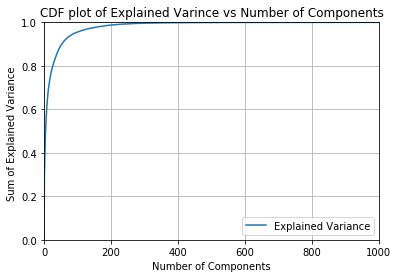

In [28]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'Explained Variance':sum_exp_var,
                  }, index= range(len(features)) )

lines = df.plot.line()
plt.xlabel("Number of Components")
plt.ylabel("Sum of Explained Variance ")
plt.title("CDF plot of Explained Varince vs Number of Components")
plt.axis([0, len(features), 0, 1])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

In [29]:
svd = TruncatedSVD(n_components = 200, random_state=42)
truncated_svd_data = svd.fit_transform(cooc_mat_df)

In [30]:
truncated_svd_data.shape

(1000, 200)

### [5.4] Applying k-means clustering

In [31]:
# Please write all the code with proper documentation

In [32]:
from sklearn.cluster import KMeans

In [33]:
ssd  = []
for i in tqdm(range(1, 201, 5)):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(truncated_svd_data)
    ssd.append(kmeans.inertia_)

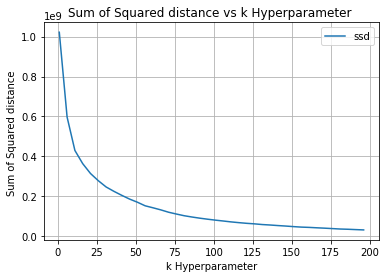

In [34]:
#printing all Auc value of corresponding k on validation and test data
df = pd.DataFrame({
                  'ssd':ssd,
                  }, index = range(1, 201, 5))

lines = df.plot.line()
plt.xlabel("k Hyperparameter")
plt.ylabel("Sum of Squared distance ")
plt.title("Sum of Squared distance vs k Hyperparameter ")
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

In [35]:
n_clusters = 75

In [36]:
kmeans = KMeans(n_clusters = n_clusters, random_state=0).fit(truncated_svd_data)

In [37]:
label = kmeans.labels_

In [38]:
cooc_mat_df['label'] = label

In [39]:
cooc_mat_df['label'].value_counts()

0     530
70    210
13     77
63     53
39     37
25     13
11      5
4       5
48      2
47      2
23      2
22      1
32      1
24      1
31      1
30      1
26      1
20      1
27      1
28      1
29      1
21      1
17      1
19      1
8       1
1       1
2       1
3       1
5       1
6       1
     ... 
59      1
60      1
61      1
62      1
65      1
36      1
66      1
67      1
68      1
69      1
71      1
72      1
56      1
55      1
54      1
53      1
52      1
51      1
50      1
49      1
46      1
45      1
44      1
43      1
42      1
41      1
40      1
38      1
73      1
37      1
Name: label, Length: 75, dtype: int64

In [40]:
top3_cluster_label = []
for i in range(3):
    top3_cluster_label.append(cooc_mat_df['label'].value_counts().index[i])

### [5.5] Wordclouds of clusters obtained in the above section

In [224]:
# Please write all the code with proper documentation

In [41]:
from wordcloud import WordCloud 

printing top 3 cluster which contains maximum word 


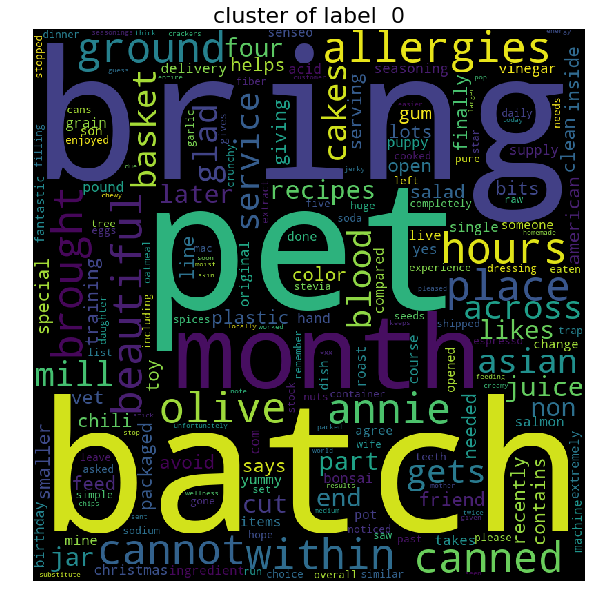

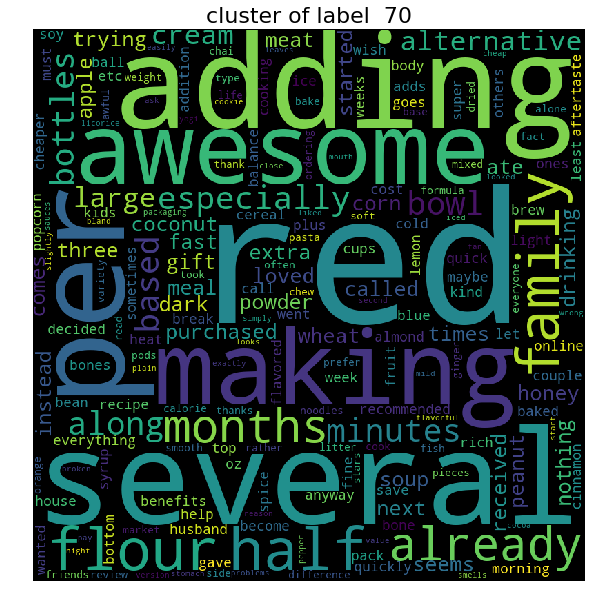

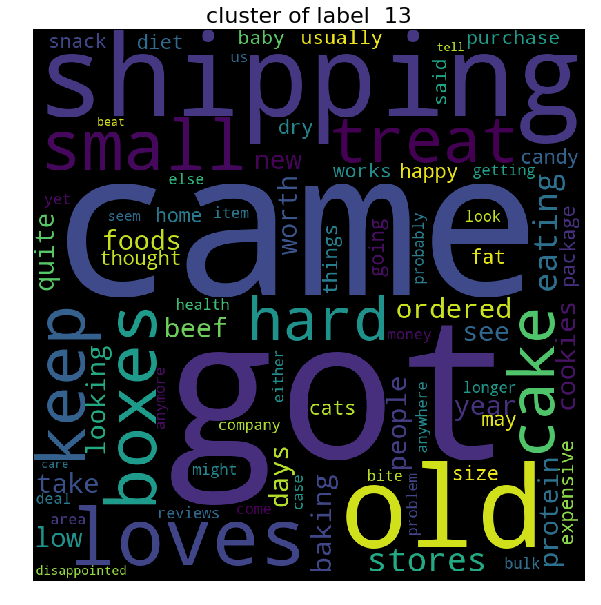

In [42]:
print("printing top 3 cluster which contains maximum word ")
for k in tqdm(top3_cluster_label):
    cluster = cooc_mat_df[cooc_mat_df['label'] == k]
    freq = np.zeros_like(range(len(cluster['label'])))
    dict_word_freq = {}
    for i in range(len(cluster['label'])):
        for j in range(len(cluster.iloc[0,:])-1):
            freq[i] = (cluster.iloc[i,j] + freq[i])     
            dict_word_freq[cluster.index[i]] = freq[i]
        if len(cluster['label'])-1 == i:
            wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black',        
                min_font_size = 5).generate_from_frequencies(dict_word_freq) 

            # plot the WordCloud image 
            
            plt.figure(figsize = (8, 8), facecolor = None) 
            plt.imshow(wordcloud) 
            plt.axis("off") 
            plt.tight_layout(pad = 0) 
            plt.title("cluster of label  " + str(k), fontsize=22)  
            plt.show()
        

### [5.6] Function that returns most similar words for a given word.

In [43]:
# Please write all the code with proper documentation

In [44]:
df = cooc_mat_df

In [45]:
def similar_word(key):
    cosine_dist = [0] * len(df.iloc[:, 1])
    k = -1
    for i in range(len(df.iloc[:, 1])):
        if key == df.index[i]:
            k = i
            key_word = df.iloc[i, :]
            break    
        else:
            if len(df.iloc[:, 1])-1 == i:
                print("Your given word is not availble in co-occurance matrix")
                match_word = None
                return key, match_word, k
            
    if k != -1:
        for i in tqdm(range(len(df.iloc[:, 1]))):
            a = 0
            b = 0
            s = cosine_dist[i]
            for j in range(len(df.iloc[1, :])):
                #cosine formula is A*B/ ||A|| ||B||
                search_word = df.iloc[i]
                s = s + (key_word[j] * search_word[j])
                a = a + (key_word[j]**2)
                b = b + (search_word[j]**2)
            cosine_dist[i] = 1 - s / (math.sqrt(a)*math.sqrt(b))
        
        cosine_dist.remove(min(cosine_dist))
        l = cosine_dist.index(min(cosine_dist))
        if k <= l:
            k = l+1
        else:
            k = l
        match_word = df.index[k]
        return key, match_word, k
    

In [46]:
word, match_word, k = similar_word('also')
if k != None:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of also is noticed


In [47]:
word, match_word, k = similar_word('across')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of across is came


In [48]:
word, match_word, k = similar_word('back')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of back is coming


In [49]:
word, match_word, k = similar_word('oil')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of oil is extra


In [50]:
word, match_word, k = similar_word('add')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of add is stir


In [51]:
word, match_word, k = similar_word('try')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of try is however


In [52]:
word, match_word, k = similar_word('nice')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of nice is wonderful


In [53]:
word, match_word, k = similar_word('milk')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of milk is water


In [54]:
word, match_word, k = similar_word('white')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Most similar word of white is regular


In [55]:
word, match_word, k = similar_word('AAIC')
if k != -1:
    print('Most similar word of {0} is {1}'.format(word, match_word))  

Your given word is not availble in co-occurance matrix


# [6] Conclusions

# Please write down few lines about what you observed from this assignment. 
# Also please do mention the optimal values that you obtained for number of components & number of clusters.

1. first we took 50K points and fit into tfidf
2. we took top 1k features using tfidf
3. Preprocessing text execpt for stop words 
4. making co-ocurrance matrix from preprocessed text using 1k features
5. reduing dimension using truncated svd by ploting grapgh b/w explained 
   varinace and number of features
6. Observed the 200 features from 1k is explaining 98% variance so that we took 
   200 featue and now our dataframe is shape of 1000, 200
7. Now finding k best cluster by using different value of k and observed that
   60 is optimal k. after 60 cluster sum of sqaure distance is not changing much 
    faster as before 60
8. Printed top 3 cluster(57, 14, 3) which had maximum no. of words 
9. wrote a function which gives similar/ close/ minimum_distance word from 
   a given word from occurance matrix which was  shape of (1000, 1000)

